### Block CNNS on FashionMNIST (VGG)
Roger Wang  
UCLA

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from torch.optim import SGD
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# FashionMNIST dataset
class FashionMNIST():
    def __init__(self, root='../data', batch_size=64, resize=(28,28)):
        self.batch_size = batch_size
        self.resize = resize

        # image transforms, resize and convert to tensor
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])

        # initialize train (60k) and val (10k) sets
        self.train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=root,train=False,transform=trans,download=True)

    # data loader for dataset
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train)
    
    # getting training data
    def train_dataloader(self):
        return self.get_dataloader(True)
    
    # getting val data
    def val_dataloader(self):
        return self.get_dataloader(False)

In [3]:
# VGG block, sequence of convolutions followed by 2x2 max pooling
# VGG block func takes # of conv and # of output channels for the block
def VGGBlock(nconv, noutputs):
    block = []
    for i in range(nconv):
        block.append(nn.LazyConv2d(noutputs,kernel_size=3,padding=1))
        block.append(nn.ReLU())
    block.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*block)

# weight initialization function
def initialize(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight) # model does not converge without initialization

# VGG Net class, implemented from paper
# blocks_list parameter is list of tuples for each block: [(num conv, num output channels), ....]
class VGGNet(nn.Module):
    def __init__(self, num_classes, blocks_list, lr=0.1, momentum=0, weight_decay=0):
        super().__init__()
        self.num_classes = num_classes
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        # create VGG blocks
        blocks = []
        for block_nconv, block_noutputs in blocks_list:
            blocks.append(VGGBlock(block_nconv,block_noutputs))
        
        # flatten and FC layers after VGG blocks
        self.net = nn.Sequential(*blocks,nn.Flatten(),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(num_classes),nn.Softmax(dim=1))
        
    # initialize weights with dummy input
    def initialize_weights(self, input, init=None):
        self.forward(input)
        if init is not None:
            self.net.apply(init)

    def forward(self,x):
        return self.net(x)
    
    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)

In [4]:
# early stopper and training loop

# early stopping class
# criterion: validation accuracy
class EarlyStop():
    def __init__(self, patience, delta=0.003):
        self.patience = patience
        self.delta = delta
        self.best = 0
        self.count = 0

    def checkForStop(self, acc):
        if acc > self.best:
            self.best = acc
            self.count = 0
            return False
        elif acc < self.best-self.delta:
            if self.count > self.patience:
                return True
            self.count = self.count + 1
            return False
        
# training loop
def train(model, trainloader, valloader, epochs):
    train_loss = []
    val_loss = []
    val_acc = []
    model.initOptimizer()
    mps = torch.device('mps')
    model.to(mps)
    stopper = EarlyStop(3)

    pbar = tqdm(range(epochs))
    for i in range(epochs):
        train_loss.append(0)
        val_loss.append(0)
        val_acc.append(0)

        model.train()
        # training over batches of train set
        for n, (traindata,trainlabel) in enumerate(trainloader):
            traindata, trainlabel = traindata.to(mps), trainlabel.to(mps)
            model.optim.zero_grad()
            logits = model.forward(traindata)
            loss = model.loss((logits,trainlabel))
            loss.backward()
            model.optim.step()

            train_loss[i] = train_loss[i] + loss.item()
        train_loss[i] = train_loss[i] / len(trainloader)

        # validation over batches of val set
        model.eval()
        for n, (val,vallabel) in enumerate(valloader):
            val, vallabel = val.to(mps), vallabel.to(mps)
            with torch.no_grad():
                logits = model.forward(val)
                loss = model.loss((logits,vallabel))
                accuracy = model.accuracy((logits,vallabel))

                val_loss[i] = val_loss[i] + loss.item()
                val_acc[i] = val_acc[i] + accuracy
        val_loss[i] = val_loss[i] / len(valloader)
        val_acc[i] = val_acc[i] / len(valloader)

        # update pbar
        pbar.update(1)
        pbar.set_description(f'val_acc: {val_acc[i]:.3f} train_loss: {train_loss[i]:.3f}')

        # check for early stopping
        if stopper.checkForStop(val_acc[i]):
            break

    pbar.close()

    # display loss and acc
    #plt.plot(train_loss, label='train_loss')
    #plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc)
    plt.xlabel('epoch')
    #plt.legend()

In [5]:
# initialize dataset
resize = (128,128)
data = FashionMNIST(batch_size=128,resize=resize)
trainloader = data.train_dataloader()
valloader = data.val_dataloader()

In [8]:
# initialize model
mps = torch.device('mps')
blocks_smallVGG = [(1,16),(1,32),(2,64),(2,128),(2,128)]
model = VGGNet(10,blocks_smallVGG,lr=0.01,momentum=0.3, weight_decay=0.01)
# initialize weights w dummy input
model.initialize_weights(next(iter(trainloader))[0],initialize)
model.to(mps)

/Users/rogerwang/opt/anaconda3/envs/torchKernel/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VGGNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, str

val_acc: 0.712 train_loss: 1.889: 100%|██████████| 10/10 [14:38<00:00, 87.80s/it]


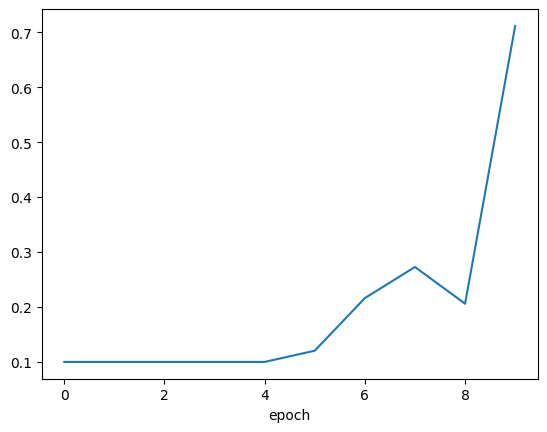

In [9]:
# training
train(model,trainloader,valloader,epochs=10)

In [10]:
# save params
torch.save(model.state_dict(),'FashionSmallVGG_122623.params')

val_acc: 0.913 train_loss: 1.518: 100%|██████████| 10/10 [15:54<00:00, 95.46s/it]


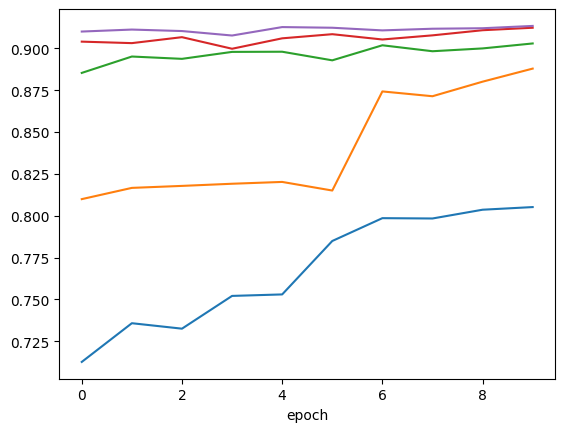

In [11]:
# continue training w mock learning rate schedule
model.momentum = 0.9
model.weight_decay = 0.0005
for i in range(5):
    model.lr = model.lr * 0.9
    train(model,trainloader,valloader,epochs=10)

In [12]:
# best val accuracy 0.913, competitive scores on kaggle: 0.92-0.94
# checkpoint model
torch.save(model.state_dict(),'FashionSmallVGG_122623_2.params')

In [15]:
# classification metrics
def classification_metrics(true, pred, labels=None):
    # turn tensors to arrays, make sure same type
    true, pred = np.array(true).astype(int), np.array(pred).astype(int) 
    
    # create confusion matrix
    cm = confusion_matrix(true,pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(xticks_rotation='vertical')

    # TP,TN,FP,FN
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    # precision and recall by class
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    # macro averaged precision and recall
    N = len(precision)
    macro_precision = np.sum(precision) / N
    macro_recall = np.sum(recall) / N

    # micro averaged precision and recall
    micro_precision = np.sum(tp) / (np.sum(tp)+np.sum(fp))
    micro_recall = np.sum(tp) / (np.sum(tp)+np.sum(fn))

    # accuracy by class
    class_accuracy = (tp+tn) / (tp+fn+fp+tn)

    # overall accuracy
    accuracy = (true == pred).mean()

    # print metrics
    if labels is None:
        labels = np.unique(true)
    print(f' Class: \t\t Accuracy: \t\t Precision: \t\t Recall: \t\t')
    for i in range(N):
        print(f'  {labels[i]}: \t\t\t {class_accuracy[i]:.3f}\t\t\t {precision[i]:.3f}\t\t\t {recall[i]:.3f}')
    print(f'\n Overall Accuracy: \t{accuracy:.3f}')
    print(f' Macro Precision: \t{macro_precision:.3f} \t\t Micro Precision: \t{micro_precision:.3f}')
    print(f' Macro Recall: \t\t{macro_recall:.3f} \t\t Micro Recall: \t\t{micro_recall:.3f}')

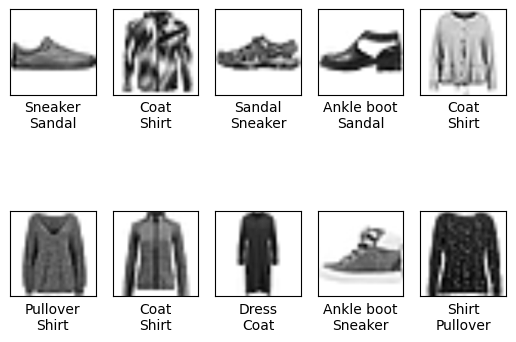

In [14]:
# where did model fail
data_2 = FashionMNIST(batch_size=500,resize=(128,128))
testloader = data_2.val_dataloader()
testdata, testlabel = next(iter(testloader))
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model.to('cpu')
model.eval()
logits = model.forward(testdata)
pred = model.predict(logits)

missed_idx = np.array((pred != testlabel).type(torch.float32))
missed_idx = np.where(missed_idx == 1)

missed = (testdata[missed_idx], testlabel[missed_idx], pred[missed_idx])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(missed[0][i][0]), cmap=plt.cm.binary)
    plt.xlabel(labels[missed[1][i].item()] + '\n' + labels[missed[2][i]])

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  T-shirt/top: 			 0.984			 0.912			 0.945
  Trouser: 			 1.000			 1.000			 1.000
  Pullover: 			 0.974			 0.906			 0.892
  Dress: 			 0.992			 0.957			 0.957
  Coat: 			 0.976			 0.925			 0.860
  Sandal: 			 0.994			 0.950			 0.974
  Shirt: 			 0.958			 0.760			 0.809
  Sneaker: 			 0.988			 0.902			 0.979
  Bag: 			 1.000			 1.000			 1.000
  Ankle boot: 			 0.990			 1.000			 0.896

 Overall Accuracy: 	0.928
 Macro Precision: 	0.931 		 Micro Precision: 	0.928
 Macro Recall: 		0.931 		 Micro Recall: 		0.928


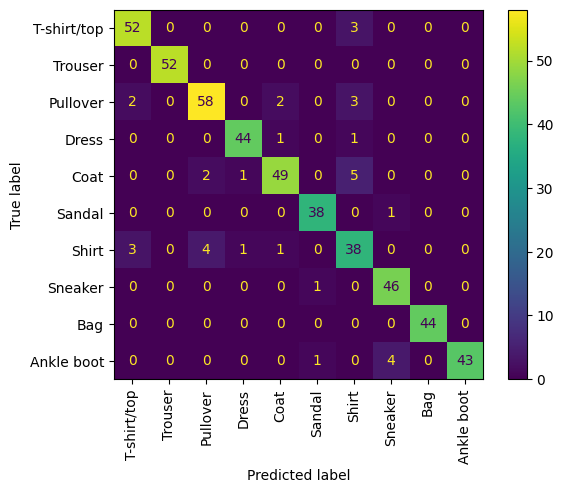

In [16]:
# display classification metrics
classification_metrics(testlabel,pred,labels=labels)

VGG has very good validation scores that are competitive with top-10 scores on Kaggle.  
  
Notice less confusion in coat category than other models (LeNet).  
  
This notebook highlights the importance of parameter initialization before training. Without a custom initializer function, the default initialized model fails to converge and training does not progress.  
  
Use block architectures to implement models module by module instead of layer by layer. VGG also stacks successive convolutions before a downsizing step, which allows deeper models to be built.